# 1 Agent-on-pores 2D model (thin agent layer)


In this first section, we try to get comfortable with FEniCS and the finite element method, by implementing it for a partial aspect of the problem at hand. 

In 2D, the nondimensional rescaled PDE for the cleanser concentration $c(x,y,t)$ becomes (whenever $R>0$, ignoring the case when $R = 0$ for now!):

\begin{equation}
c_t = \nabla^2 c - (1+\chi^\star c)c.
\end{equation}

This comes from equation $(6.7)$ in the first draft of the paper. 

Assume that we are working in a spatial domain $\Omega$, that the initial concentration is prescribed as a non-dimensional function, i.e. $c(x,y,0) = c_0$, and that the concentration is known on (parts of) the boundary, i.e. $c = c_D$ on $\partial \Omega$. We take $c_0 \equiv 0$, since we assume that there is no cleanser initially, before we start to decontaminate the spill.

To start off, we solve the problem over a unit square, so that $\Omega = [0,1] \times [0,1]$. The appropriate boundary conditions for our physical situation are as follows: there is cleanser on the surface, with the deepest point and the ends being insulated:

\begin{equation}
c(x,0,t) = 1, \\
\dfrac{\partial c}{\partial y}(x,1,t) = 0, \\
\dfrac{\partial c}{\partial x}(0,y,t) = 0, \\
\dfrac{\partial c}{\partial x}(1,y,t) = 0.
\end{equation}

Physically, the conditions correspond to the following observations:


#### 1. Initially, there is no cleanser applied and the radius of the coating agent is prescribed. 
#### 2. The cleanser is applied at the surface of the spill $(y=0)$ with a known initial concentration.
#### 3. No cleanser can leave our porous box, so the side ends and the bottom are insulated. 

These boundary conditions are mixed (Dirichlet and Neumann): we have Dirichlet conditions at $y=0, y=1$ (as we specify the cleanser concentration) and Neumann conditions at $y=0, y=1$ (due to the insulation). The Dirichlet conditions are called <b>essential</b> boundary conditions, since we encode them in the definition of spaces. Meanwhile, the Neumann condition is encoded in the variational form itself - this is a <b>weakly imposed</b> boundary condition. 

The approach is to discretise the time derivative, to obtain many stationary problems on the grid. In turn, each of these stationary problems into variational problems, placed into weak form and solved using the finite element method in FEniCS. 

The superscripts denote the timepoint at which we evaluate the solution, so that $c^n$ is the cleanser concentration at time $t_n$. Using an implicit difference scheme, at time $t_{n+1}$ our discretised problem reads:

\begin{equation}
\dfrac{c^{n+1}-c^n}{\Delta t} = \nabla^2 c^{n+1} - (1+\chi^\star c^{n+1})c^{n+1},
\end{equation}

or placing late terms on the left side and early terms on the right side:

\begin{equation}
c^{n+1} - \Delta t \nabla^2 c^{n+1} + \Delta t (1+\chi^\star c^{n+1})c^{n+1}= c^n.
\end{equation}

Introduce the new spaces: 

\begin{equation}
V = \{v \in H^1(\Omega) | v = c_D \text{ on } \partial \Omega \cap \{ y=0 \} \}, \\
\hat{V} = \{v \in H^1(\Omega) | v = 0 \text{ on } \partial \Omega \cap \{ y=0 \} \},
\end{equation}

which are the (continuous) function spaces that contain our solutions and the suitable test functions for the variational problem, respectively. We implicitly work with strict subspaces of these spaces in seeking solutions to the discretised problem (finite dimensional Galerkin approximations).

Next, we multiply the discretised problem by a test function $v$ which vanishes on the boundary of the domain (wherever the solution is actually specified), and we write $c$ for $c^{n+1}$ (thereby keeping $c^n$ in its original notation). Using Green's theorem in the second equality and since the test function vanishes on $\partial \Omega \cap \{ y = 0 \}$ and $\partial \Omega \cap \{ y = 1 \}$, whereas the normal derivative of $c$ vanishes on the remainder of the boundary:

\begin{equation}
\int_{ \Omega} v \nabla^2 c dxdy= \int_{ \Omega} \nabla \cdot (v \nabla c) dxdy - \int_{ \Omega} \nabla v \cdot \nabla c dxdy = \int_{\partial \Omega} v \dfrac{\partial c}{\partial n} ds- \int_{ \Omega} \nabla v \cdot \nabla c dxdy = - \int_{ \Omega} \nabla v \cdot \nabla c dxdy.
\end{equation}

<b> The important takeaway here is that no boundary integrals remain and the variational formulation is as simple as possible. </b> 

Therefore, in integral form the problem becomes: find $u \in V$ such that for any $v \in \hat{V}$, we have:

\begin{equation}
F_{n+1}(c;v) = \int_{\Omega} vc + \Delta t (\nabla v \cdot \nabla c) + v \Delta t (1+ \chi^\star c)c - vc^n dx dy = 0.
\end{equation}

Note that this problem is not in the canonical form $F(c;v) = 0 = a(c;v) - L(v)$, where $a$ is a bilinear form and $L$ is a linear mapping, because of the nonlinearity due to the extra diffusion terms. However, we may simply leave the problem in this form, and FEniCS automatically handles the non-linearity using Newton-Kantorovich, provided it converges in sufficiently many steps.

We can actually go one step further to improve the stability and accuracy of this method, by considering an <b> implicit midpoint </b> method. In particular, we only need to change the right hand side to reflect the average of our variable at times $t_{n+1}$ and $t_n$, as follows: 

\begin{equation}
\dfrac{c^{n+1}-c^n}{\Delta t} = \dfrac{1}{2} \nabla^2 \left( c^{n+1} +  c^{n} \right) - \left(1+\chi^\star \dfrac{c^{n+1}+c^n}{2}\right) \dfrac{c^{n+1}+c^n}{2}.
\end{equation}

In the code below, this is reflected by defining $\tilde{c} = \frac{1}{2} \left( c^{n+1} + c^{n} \right)$ and using it as a replacement for c, everywhere except for the term due to the time derivative on the left hand side. This gives a new variational formulation (upon division by $\Delta t$):

\begin{equation}
F_{n+1}(c;v) = \int_{\Omega} \dfrac{v(c-c^n)}{\Delta t} + \nabla v \cdot \nabla \tilde{c} + v  (1+ \chi^\star \tilde{c})\tilde{c} dx dy = 0.
\end{equation}

We can then simulate the solution of the equation as follows:

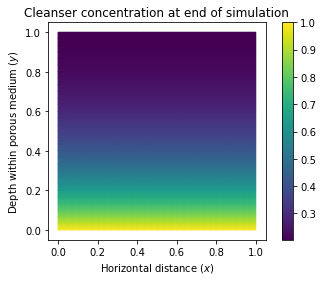

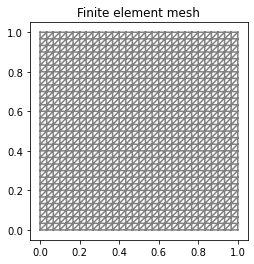

In [21]:
from __future__ import print_function
from fenics import * # imports the key classes UnitSquareMesh, FunctionSpace, Function etc.
import numpy as np # we'll need this, always - most matrix-y operations use numpy
from matplotlib import pyplot as plt # go-to plotter, MATLAB style
 
T = 5           # time of solution (end of simulation)
num_steps = 10     # number of time steps
dt = T / num_steps # time step size (predetermined by the number of timesteps)
chi = 1         # parameter chi star
degree = 1 # the degree that determines the kind of elements we are using for the function space


# Create mesh and define function space
nx = ny = 30 # Specifying the resolution of our triangular mesh
mesh = UnitSquareMesh(nx, ny) # Uniform, finite element mesh over the unit square.
# The mesh consists of cells, which in 2D are triangles with straight lines.

V = FunctionSpace(mesh, 'P', degree)
# A finite element function space. The second argument specifies the type of element.
# 'P' means that we are using the standard Lagrange family of elements.
# The third argument specifies the degree of the finite element.
# Patrick says that this is a sensible choice and should do the job, so I will stick with it. 

# Define boundary condition - there is no cleanser initially at t = 0!
c_init = Expression('0', degree=2, t=0) 
# Here x[0] is our usual x (horizontal distance), x[1] is our y (vertical distance)
# Warning! Expressions must have a C syntax for inline branching, not a Python one.

tol = 1e-14 # a tiny tolerance that helps us locate the suitable parts of the boundary. 

class BoundaryX0(SubDomain): # defining the boundary at x = 0
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0, tol)

class BoundaryX1(SubDomain): # defining the boundary at x = 1
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 1, tol)

class BoundaryY0(SubDomain): # defining the boundary at y = 0
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0, tol)

class BoundaryY1(SubDomain): # defining the boundary at y = 1
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 1, tol)  
    
# We are working with facets, so from the FEniCS documentation we need -1 of the dimension of the mesh topology. 
# If instead we wanted to work with vertices, the dimension would be -2. 
boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim()-1, 0) 
# This was previously done with a FacetFunction, which has now deprecated within FEniCS. 
boundary_markers.set_all(9999)
bx0 = BoundaryX0()
bx1 = BoundaryX1()
by0 = BoundaryY0()
by1 = BoundaryY1()
bx0.mark(boundary_markers, 0) # Assigning a "0" marker to x = 0 
bx1.mark(boundary_markers, 1) # Assigning a "1" marker to x = 1 
by0.mark(boundary_markers, 2) # Assigning a "2" marker to y = 0 
by1.mark(boundary_markers, 3) # Assigning a "3" marker to y = 1 

# In this dictionary, we specify the kinds of boundary conditions we are dealing with. 
# There are three possibilities: Dirichlet, Neumann and Robin.
# For each kind of condition, to the right we specify the function that this condition is assigned.

boundary_conditions = {0: {'Neumann': Expression('0', degree=2)}, # insulated left end
                        1: {'Neumann': Expression('0', degree=2)}, # insulated right end
                        2: {'Dirichlet': Expression('1', degree=2)}, # initial cleanser concentration on surface
                        3: {'Neumann': Expression('0', degree=2)}} # no cleanser has penetrated the maximum depth

bcs = [] # We first start with an empty array of boundary conditions. 
# Next, we fill this array only with Dirichlet conditions, since these are the only ones which are taken 
# into account explicitly, as opposed to within the variational formulation of the problem itself. 
for i in boundary_conditions:
    if 'Dirichlet' in boundary_conditions[i]:
        bc = DirichletBC(V, boundary_conditions[i]['Dirichlet'],
                        boundary_markers, i)
        bcs.append(bc)

# Define initial value
c_n = interpolate(c_init, V)
#c_n = project(u_D, V), depending on whether we want to interpolate or project the boundary data.

# Define variational problem

c = interpolate(c_init, V) # A good initial guess is our initial value! 
v = TestFunction(V)

# The "c tilde" for the implicit midpoint method. 
c_=1/2*(c+c_n)

# Variational formulation
F = (c-c_n)/dt*v*dx + dot(grad(c_), grad(v))*dx + v*(1 + chi*c_)*c_*dx
# language used to express this syntax is UFL (Unified Form Language) and is integral to FEniCS.

# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt # add the timestep to the current time to move forward
    c_init.t = t # update the time 

    # Compute solution
    solve(F == 0, c, bcs) # Apply Newton-Kantorovich to nonlinear problem, with the specified boundary conditions

# Plot solution at the end of the simulation
plt.figure(0)
simulationplot = plot(c, title = "Cleanser concentration at end of simulation", mode = 'color')
plt.xlabel("Horizontal distance $(x)$")
plt.ylabel("Depth within porous medium $(y)$")
    
# Plot the colorbar for the given problem
plt.colorbar(simulationplot)

# Visualising the triangular mesh used to give the solution
plt.figure(1)
plot(mesh, title = "Finite element mesh")
 

#  2 Agent-on-pores 2D model (general)


In 2D, the nondimensional coupled PDEs for $c(x,y,t)$ and $R(x,y,t)$ become (equation $(3.36)$ of the final version of the paper):

\begin{equation}
c_t = \dfrac{1}{\mathcal{V}(R)} \nabla \cdot \left( \mathcal{V}(R) \mathbf{D} \nabla c \right) - \mathcal{H}(R) \mathcal{F}(R) (1+ \gamma c) \beta c, \\
R_t = - \mathcal{H}(R) \beta \gamma c,
\end{equation}

where $\mathcal{H}(R)$ is the Heaviside function, which is $0$ for $R<0$, equals $1$ for $R>0$, and we set it to be $0$ for $R = 0$. 

Here, we also use the following notation: 
- $\mathbf{D} = \mathbf{D}(R+r)$: the effective diffusivity (depending on the pore and the agent coating), proportional to the identity matrix due to the symmetry of the circular geometry. 
- $\mathcal{V}(R)$: the 2D area occupied by the cleanser in the unit cell, $1 - \pi(r+R_0)^2$.
- $\mathcal{L}(R)$: the length of the agent-cleanser interface, $2 \pi (r+R_0)$.
- $\mathcal{F}(R)$: the ratio $\mathcal{L}(R)/ \mathcal{V}(R)$.

We solve the problem on a more general rectangular domain $\Omega = [0,a] \times [0,b]$. The accompanying boundary conditions for the cleanser concentration remain the same as before: 

\begin{equation}
c(x,0,t) = 1, \\
\dfrac{\partial c}{\partial y}(x,b,t) = 0, \\
\dfrac{\partial c}{\partial x}(0,y,t) = 0, \\
\dfrac{\partial c}{\partial x}(a,y,t) = 0.
\end{equation}

Note the second condition can either be a normal derivative or $c(x,b,t) = 0$, depending on whether we consider a Neumann or a Dirichlet scenario. There is also an initial condition for the first-order PDE for $R$ and for $c$:

\begin{equation}
R(x,y,0) = R_0. \\
c(x,y,0) = 0. 
\end{equation}

We obtain the variational formulation by multiplying with a suitable test function and summing up the two equations. But first, we need to introduce a discretisation in time. With the notation and approach as in the previous section, the PDEs become (at time $t_{n+1}$):

\begin{equation}
\mathcal{V}(R) (c^{n+1} - c^{n}) = \Delta t \nabla \cdot \left( \mathcal{V}(R) \mathbf{D} \nabla c^{n+1} \right)- \Delta t \mathcal{H}(R) \mathcal{L}(R) (1+ \gamma c^{n+1}) \beta c^{n+1}, \\
R^{n+1} - R^{n} = - \Delta t \mathcal{H}(R) \beta \gamma c^{n+1}.
\end{equation}

Next, we multiply by a test function $v$ (which vanishes on the boundary $y=0$), so that by integration by parts:

\begin{equation}
\int_{\Omega} v \nabla \cdot \left( \mathcal{V}(R) \mathbf{D} \nabla c \right) dx dy = \int_{\partial \Omega} v \mathbf{D} \mathcal{V}(R) \nabla c \cdot \mathbf{n} ds - \int_{\Omega} \nabla v \cdot \mathbf{D} \mathcal{V}(R)  \nabla c dx dy = - \int_{\Omega} \nabla v \cdot \mathbf{D} \mathcal{V}(R)  \nabla c dx dy.
\end{equation}

The line integral vanishes for the same reason as in the previous scenario (coating of agent layer thin compared to the pore lengthscale), and we work with the same spaces for our solution and the test function as previously. 

Unlike the previous case, we need to be careful with the space of test functions we work with, and introduce two different test functions in the problem (as this is a system of two coupled PDEs). We let $v_1$ be the test function corresponding to the PDE with the $c$ time derivative, and let $v_2$ be the test function corresponding to the PDE with the $R$ time derivative.

Next, dropping $n+1$ superscripts, our variational problem becomes:

\begin{equation}
F_{n+1}(c, R; v_1,  v_2) = \int_{\Omega} \dfrac{v_1 \mathcal{V}(R)(c-c^n)}{\Delta t} + \nabla v_1  \cdot \left( \mathbf{D} \mathcal{V}(R) \nabla c \right) + v_1 \mathcal{H}(R) \mathcal{L}(R) (1 + \gamma c)\beta c + \dfrac{v_2 (R-R^{n})}{\Delta t} + v_2 \mathcal{H}(R) \beta \gamma c dx dy = 0.
\end{equation}

In fact, if we implement an implicit midpoint method, we may set:

\begin{equation}
\tilde{c} = \dfrac{1}{2} \left( c^{n+1} + c^{n} \right),
\end{equation}

and replace all $c^{n+1}$ terms that do not come from the time derivatives as previously, to obtain:

\begin{equation}
F_{n+1}(c, R;v_1, v_2) = \int_{\Omega} \dfrac{v_1 \mathcal{V}(R)(c-c^n)}{\Delta t} + \nabla v_1  \cdot \left( \mathbf{D} \mathcal{V}(R) \nabla \tilde{c} \right) + v_1 \mathcal{H}(R) \mathcal{L}(R) (1 + \gamma \tilde{c})\beta \tilde{c} + \dfrac{v_2(R-R^{n})}{\Delta t} + v_2 \mathcal{H}(R) \beta \gamma \tilde{c} dx dy = 0.
\end{equation}

<b>This is one of the strengths of FEniCS: one can easily define variational problems that couple several PDEs into one compound system.</b> The result is a fully implicit (monolithic) solver. 

## 3.1 Interpolating the effective diffusivity

Here we use polynomial interpolation to create a new function, which will output the effective diffusivity within the porous medium for a given size of pore and coating layer (which together clog the medium diffused by the cleanser).

In [22]:
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt # go-to plotter, MATLAB style
    
# We define a function which outputs the diffusivity for a given radius 
def effectivediffusivity(r):
    
    R1 = np.linspace(0,0.47,48) # Radii 0, 0.1, 0.2, ... , 0.47
    R2 = np.linspace(0.471,0.5,30) # Smaller steps for radii: 0.471, 0.472, ... , 0.5
    R = np.concatenate((R1, R2)) # All 78 arguments for calculations placed into one array. 

    # Effective diffusivities  for the particular radii from correspondence with  Mo Dalwadi. 

    D = np.array([1.0000, 0.9997, 0.9988, 0.9972, 0.9950, 0.9922, 0.9888, 0.9849, 0.9803, 0.9752,
                0.9696, 0.9634, 0.9567, 0.9496, 0.9420, 0.9340, 0.9256, 0.9168, 0.9076, 0.8982,
                0.8884, 0.8783, 0.8680, 0.8574, 0.8467, 0.8357, 0.8246, 0.8133, 0.8019, 0.7904,
                0.7787, 0.7668, 0.7548, 0.7427, 0.7303, 0.7177, 0.7048, 0.6915, 0.6776, 0.6631,
                0.6476, 0.6310, 0.6127, 0.5921, 0.5684, 0.5401, 0.5051, 0.4596, 0.4543, 0.4487,
                0.4430, 0.4370, 0.4309, 0.4244, 0.4178, 0.4109, 0.4036, 0.3961, 0.3883, 0.3800,
                0.3714, 0.3624, 0.3528, 0.3428, 0.3322, 0.3209, 0.3089, 0.2962, 0.2824, 0.2677,
                0.2516, 0.2340, 0.2145, 0.1925, 0.1671, 0.1365, 0.0962, 0.0000])
    
    
    # We use cubic interpolation in order to smooth out the resulting curve
    # This shouldn't be too dramatic as the function is monotonic anyways
    f_cubic = interp1d(R, D, 'cubic') 
    plt.plot(R, D, 'o', R, f_cubic(R), '--',)
    plt.xlabel("Radius of circle inscribed in unit square cell")
    plt.ylabel("Effective diffusivity in porous medium")
    plt.legend(['Data', 'Cubic interpolation'], loc = 'best')
    plt.show()
    
    return float(f_cubic(r))

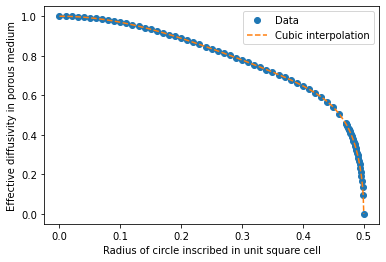

0.7787000000000001

In [23]:
effectivediffusivity(0.3)

## 3.2 Setting up the suitable Heaviside approximation, $\mathcal{V}(R)$, and $\mathcal{L}(R)$

For whatever reason, FEniCS does not like using Heaviside functions in its variational formulation. The result is:
<b> TypeError: </b> ufunc 'heaviside' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

For that reason, we use an infinitely smooth approximation to it. For us, it is important that $H(0) = 0$, so we slightly skew the approximation to the right (rather than obeying symmetry about the $y$-axis) in order to achieve this.

A good smooth approximation to the Heaviside function is provided by the logistic function: 

\begin{equation}
H(x) = \dfrac{1}{2} + \dfrac{1}{2} \tanh kx,
\end{equation}

with a larger value of $k$ corresponding to a sharper transition at the origin. However, this gives $H(0) = 1/2$, so we shift the function slightly so we seek a constant $c$ such that:

\begin{equation}
H(x) = \dfrac{1}{2} + \dfrac{1}{2} \tanh \left(kx + c \right) 
\end{equation}

satisfies  $H(0) =  0 $. Note that this implies $\tanh c = -1$, so by monotonicity of $\tanh$ this means $ c = - \infty$. However, setting $c = -100$, the result is correct to more than $20$ decimal places, which should be a good enough approximation for us. 

We also need to define functions for the local length of the agent-cleanser interface and the area of the cleanser-occupied region, which enter the variational formulation of the problem as seen above. 

In [24]:
import numpy as np 

def heav(R): # Heaviside function approximation.
    k = 10e15 # Large value of k makes the function sharper.
    return 1/2 + 1/2*np.tanh(k*R-100) # making sure we get H(R) = 0 when R = 0. 

def vol(R,r): # Area of cleanser occupied region. 
    return 1 - np.pi *(r+R)**2

def leng(R,r): # Local length of agent-cleanser interface.
    return 2*np.pi*(r+R)

In [26]:
from __future__ import print_function
from fenics import * # imports the key classes UnitSquareMesh, FunctionSpace, Function etc.
import numpy as np # we'll need this, always - most matrix-y operations use numpy
import sympy as sym 
from matplotlib import pyplot as plt # go-to plotter, MATLAB style
from scipy.interpolate import interp1d
 
def agentonpores(T, num_steps, r, a, b, R_0, c_0, beta, gamma, bc_bottom):    
    dt = T / num_steps # time step size (predetermined by the number of timesteps)
    degree = 1 # the degree that determines the kind of elements we are using for the function space
    
    def vol(R,r): # Area of cleanser occupied region. 
        return 1 - np.pi *(r+R)**2

    def leng(R,r): # Local length of agent-cleanser interface.
        return 2*np.pi*(r+R)
    
    R1 = np.linspace(0,0.47,48) # Radii 0, 0.1, 0.2, ... , 0.47
    R2 = np.linspace(0.471,0.5,30) # Smaller steps for radii: 0.471, 0.472, ... , 0.5
    R_tot = np.concatenate((R1, R2)) # All 78 arguments for calculations placed into one array. 

    # Effective diffusivities for the particular radii of pores. 

    D = np.array([1.0000, 0.9997, 0.9988, 0.9972, 0.9950, 0.9922, 0.9888, 0.9849, 0.9803, 0.9752,
                0.9696, 0.9634, 0.9567, 0.9496, 0.9420, 0.9340, 0.9256, 0.9168, 0.9076, 0.8982,
                0.8884, 0.8783, 0.8680, 0.8574, 0.8467, 0.8357, 0.8246, 0.8133, 0.8019, 0.7904,
                0.7787, 0.7668, 0.7548, 0.7427, 0.7303, 0.7177, 0.7048, 0.6915, 0.6776, 0.6631,
                0.6476, 0.6310, 0.6127, 0.5921, 0.5684, 0.5401, 0.5051, 0.4596, 0.4543, 0.4487,
                0.4430, 0.4370, 0.4309, 0.4244, 0.4178, 0.4109, 0.4036, 0.3961, 0.3883, 0.3800,
                0.3714, 0.3624, 0.3528, 0.3428, 0.3322, 0.3209, 0.3089, 0.2962, 0.2824, 0.2677,
                0.2516, 0.2340, 0.2145, 0.1925, 0.1671, 0.1365, 0.0962, 0.0000])

    # We use cubic interpolation in order to smooth out the resulting curve

    diffvals = interp1d(R_tot, D, 'cubic') 
    
    # Approximation to the Heaviside function using interpolation

    Rad = np.array([-1,0,10e-14,1]) # The domain where we evaluate the Heaviside function
    Heavisideapprox = np.array([0, 0, 1, 1]) 
    heavivals = interp1d(Rad, Heavisideapprox, 'linear') 


    # Create mesh and define function space
    nx = ny = 100 # Specifying the resolution of our triangular mesh
    mesh = RectangleMesh(Point(0.0, 0.0), Point(a, b), nx, ny, "crossed")
    # Uniform, finite element mesh over the unit square.
    # The mesh consists of cells, which in 2D are triangles with straight lines.

    # Defining a MixedElement as the product space of two simple finite elements.
    # Afterwards, using the mixed element to define the function space.

    # V = VectorFunctionSpace(mesh, 'P', 2, degree)
    P1 = FiniteElement('P', triangle, degree)
    element = MixedElement([P1, P1])
    V = FunctionSpace(mesh, element)
    # 'P' means that we are using the standard Lagrange family of elements.
    # The third argument specifies the degree of the finite element.
    # Patrick says that this is a sensible choice and should do the job, so I will stick with it. 
    
    VR = V.sub(1).collapse() # We extract the subspace of the second component (R)
    diffu = Function(VR) # The effective diffusivity is a function of R, so lives in this space
    heavi = Function(VR) # The heaviside function is a function of R, so lives in this space

    # Define boundary condition - there is no cleanser initially at t = 0!
    # The first condition corresponds to no cleanser, the second to the initial radius.
    
    u_0 = Expression((str(c_0), str(R_0)), degree=1)
    
    tol = 1e-14 # a tiny tolerance that helps us locate the suitable parts of the boundary. 

    class BoundaryX0(SubDomain): # defining the boundary at x = 0
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0, tol)

    class BoundaryXa(SubDomain): # defining the boundary at x = a
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], a, tol)

    class BoundaryY0(SubDomain): # defining the boundary at y = 0
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], 0, tol)

    class BoundaryYb(SubDomain): # defining the boundary at y = b
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], b, tol)  
    
    # We are working with facets, so from the FEniCS documentation we need -1 of the dimension of the mesh topology. 
    # If instead we wanted to work with vertices, the dimension would be -2. 
    boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim()-1, 0) 
    # This was previously done with a FacetFunction, which has now deprecated within FEniCS. 
    boundary_markers.set_all(9999)
    bx0 = BoundaryX0()
    bxa = BoundaryXa()
    by0 = BoundaryY0()
    byb = BoundaryYb()
    bx0.mark(boundary_markers, 0) # Assigning a "0" marker to x = 0 
    bxa.mark(boundary_markers, 1) # Assigning a "1" marker to x = a
    by0.mark(boundary_markers, 2) # Assigning a "2" marker to y = 0 
    byb.mark(boundary_markers, 3) # Assigning a "3" marker to y = b 

    # In this dictionary, we specify the kinds of boundary conditions we are dealing with. 
    # There are three possibilities: Dirichlet, Neumann and Robin.
    # These conditions refer to the cleanser concentration, not to the radius of agent.
    # For each kind of condition, to the right we specify the function that this condition is assigned.

    boundary_conditions_cleanser = {0: {'Neumann': Expression('0', degree=1)}, # insulated left end
                            1: {'Neumann': Expression('0', degree=1)}, # insulated right end
                            2: {'Dirichlet': Expression('1', degree=1)}, # applied cleanser concentration on surface
                            3: {bc_bottom : Expression('0', degree=1)}} # insulated maximum depth / no cleanser

    bcs = [] # We first start with an empty array of boundary conditions, which we then fill.

    # Next, we fill this array only with Dirichlet conditions, since these are the only ones which are taken 
    # into account explicitly, as opposed to Neumann conditions within the variational formulation itself. 

    # We apply the boundary conditions to V.sub(0) - the cleanser (indexing in Python starts from zero)
    # This next for loop skips over anything that is not Dirichlet
    for i in boundary_conditions_cleanser:
        if 'Dirichlet' in boundary_conditions_cleanser[i]:
            bc = DirichletBC(V.sub(0), boundary_conditions_cleanser[i]['Dirichlet'],
                            boundary_markers, i)
            bcs.append(bc)

    # Define initial value for the solution vector, using the initial condition we set above.
    u_n = interpolate(u_0, V)
    #c_n = project(u_D, V), depending on whether we want to interpolate or project the boundary data.

    u =  interpolate(u_0, V) # A good initial guess = initial value! Newton is local, so we start close.
    v_1, v_2 = TestFunctions(V) # Test functions for cleanser PDE and radius PDE, respectively. 
    c, R = split(u) # The components of the solution vector (cleanser first, then radius).
    c_n, R_n = split(u_n) # The components of the discretised iterations, as above. 
    
    diffu.vector()[:] = float(diffvals(r+R_0)) # start from the effective diffusion at t=0 as initial guess 
    heavi.vector()[:] = float(heavivals(R_0)) # start from heaviside evaluated at initial radius

    c_= 0.5*(c+c_n)     # The "c tilde" for the implicit midpoint method

    # Variational formulation
    F = (c-c_n)/dt*v_1*vol(R,r)*dx + dot(grad(c_), grad(v_1))*vol(R,r)*diffu*dx \
    + v_1*heavi*leng(R,r)*beta*c_*(1+gamma*c_)*dx + v_2*(R-R_n)/dt*dx \
    + v_2*heavi*beta*gamma*c_*dx
    # language used to express this syntax is UFL (Unified Form Language) and is integral to FEniCS.

    # Time-stepping
    t = 0
    for n in range(num_steps):
        
        print(f"Step {n+1}") # Get a sense of how quickly our solver is converging

        # Update current time
        t += dt # add the timestep to the current time to move forward
        u_0.t = t # update the time 

        # Compute solution
        solve(F == 0, u, bcs) # Apply Newton-Kantorovich to nonlinear problem, with the specified boundary conditions
        
        # Split components of solution to evaluate the functions of R
        c, R = u.split(True)
        diffu.vector().set_local(diffvals(r+R.vector()[:])) # Evaluate the effective diffusivity 
        heavi.vector().set_local(heavivals(R.vector()[:])) # Evaluate the heaviside of the radius
        
    # Plot solution at the end of the simulation
    plt.figure(0)
    simulationplot1 = plot(c, title = "Cleanser concentration at end of simulation", mode = 'color')
    plt.colorbar(simulationplot1)
    plt.xlabel("Horizontal distance $(x)$")
    plt.ylabel("Depth within porous medium $(y)$")

    plt.figure(1)
    simulationplot2 = plot(R, title = "Radius of agent coating at end of simulation", mode = 'color')
    plt.colorbar(simulationplot2)
    plt.xlabel("Horizontal distance $(x)$")
    plt.ylabel("Depth within porous medium $(y)$")

## 3.3 Interactive Solver

No need to read messy code - simply plug in your desired parameters in the solver below and let's hope the results are sensible!

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50


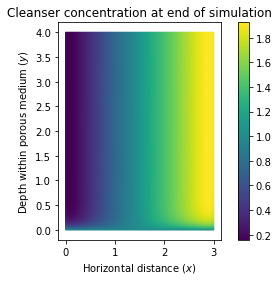

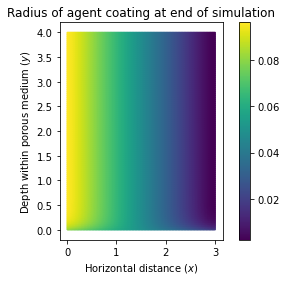

In [28]:
# TIME PARAMETERS: 

T = 2 # T is the time of simulation 
num_steps = 50 # num_steps are the number of timesteps in the discretisation of the grid

# PROBLEM GEOMETRY SPECIFICATION:

# We solve the problem on a rectangle: [0,a] x [0,b]
a = 3 # a is the maximum horizontal distance from the origin
b = 4 # b is the maximum depth of the porous medium 
r = 0.3 # r is the radius of the pore that clogs the medium

# PARAMETERS OF REACTION DUE TO CHEMISTRY:

beta = 1 # beta is the ratio of diffusion macroscale timescale / chemical reaction timescale  
gamma = 1 # gamma is the amount the interface moves due to these effects

# INITIAL CONDITIONS ON CLEANSER AND RADIUS

R_0 = 0.1 # R_0 is the initial radius of the coating layer, which is 0 < R < 1/2 - r
c_0 = 'x[0]' # c_0 is the initial concentration of cleanser applied to the surface

# BOUNDARY CONDITION AT BOTTOM OF MEDIUM 

bc_bottom = 'Neumann' # Choose between Dirichlet or Neumann conditions

agentonpores(T, num_steps, r, a, b, R_0, c_0, beta, gamma, bc_bottom)

# 4 Asymptotics for thin coating layer

## 4.1 Simplifying the existing model

Recall that our model is given by:

\begin{equation}
c_t = \dfrac{1}{\mathcal{V}(R)} \nabla \cdot \left( \mathcal{V}(R) \mathbf{D} \nabla c \right) - \mathcal{H}(R) \mathcal{F}(R) (1+ \gamma c) \beta c, \\
R_t = - \mathcal{H}(R) \beta \gamma c.
\end{equation}

If we assume that the initial coating layer of agent is very small ($R_0 \ll r$), then $\mathcal{V} \approx 1 - \pi r^2$, $\mathcal{L} \approx 2 \pi r$, and the diffusivity tensor is just $\mathbf{D} = D_0 \mathbf{I}$. Here, $D_0$ is the initial (and subsequently constant) diffusivity due to clogging by the pore with no contribution from the agent layer. Therefore, the governing equations for the model become (writing $\nu$ for $\mathcal{F}(R)$ which is now constant): 

\begin{equation}
c_t = D_0  \nabla^2 c - \mathcal{H}(R) \nu (1+ \gamma c) \beta c, \\
R_t = - \mathcal{H}(R) \beta \gamma c.
\end{equation}

In the derivation of the model, we assume that both $\beta$ and $\gamma$ are $O(1)$ constants, so the resulting model corresponds to the distinguished limit in which the diffusion and reaction terms are both present. 

Below is a plot of the parameter $\nu$, which grows monotonically with the pore radius. 

In [ ]:
import numpy as np 
from matplotlib import pyplot as plt

r = np.linspace(0,0.5,100)
nu = 2*np.pi*r / (1-np.pi*r**2)
plt.plot(r,nu)
plt.xlabel("Radius of pore of medium $(r)$")
plt.ylabel("Value of nu")
plt.show()

## 4.2 Rescaling the simplified model for early time behaviour

If $c^{\star}$ is the applied cleanser concentration at $y=0$ and $R_0$ is the initial radius of the coating (recall $R_0 \ll 1$), then we write $R = R_0 \tilde{R}$ and $c = c^{\star} \tilde{c}$.

Also, rescaling $\mathbf{r} = \sqrt{\dfrac{D_0}{\nu \beta}} \tilde{r}$ and the time as $t = \dfrac{1}{\nu \beta } \tilde{t}$, upon dropping the tilde's, our rescaled model becomes:

\begin{equation}
c_t = \nabla^2 c - \mathcal{H}(R) (1 + \gamma c^{\star}c)c, \\
\nu R_0 R_t = - \mathcal{H}(R) \gamma c^{\star} c. \\
\end{equation}

Note that for realistic pore sizes, $\nu$ ranges up to at most $\approx 15$, whereas the small coating layer $R_0 \ll 1$, so the assumption $\epsilon := \nu R_0 \ll 1$ is probably realistic. Setting $\alpha := \gamma c^{\star}$, the model is: 

\begin{equation}
c_t = \nabla^2 c -  (1 + \alpha c)\mathcal{H}(R)c, \\
\epsilon R_t = - \alpha \mathcal{H}(R) c. \\
\end{equation}

We can see from this final equation for $R$ that $c \sim O(\epsilon)$ when $R > 0$, except when $t$ is small so that the left-hand side is non-negligible. 

To examine early-time behaviour, we rescale $\mathbf{r} = \sqrt{\epsilon} (X,Y)$ and $t = \epsilon \tau$. Writing $\nabla$ for $\nabla _{X}$, at leading order in $\epsilon$ the model becomes:

\begin{equation}
C_\tau = \nabla^2 C, \\ 
R_\tau = - \alpha \mathcal{H}(R) C.
\end{equation}

Suppose we have boundary conditions as before: 
\begin{equation}
C(X,0,\tau) = 1, \\
\dfrac{\partial C}{\partial X}(0,Y,\tau) = 0, \\
\dfrac{\partial C}{\partial X}\left(\frac{a}{\sqrt{\epsilon}},Y,\tau \right) = 0,
\end{equation}

and either a zero Neumann or zero Dirichlet boundary condition at $Y = b / \sqrt{\epsilon}$. Then, since $C$ and $R$ are independent of $X$ initially and at the boundary, we seek a solution $C(X,Y,\tau) \equiv C(Y, \tau)$. Because of the symmetry in the boundary conditions, we seek a similarity solution as follows:

\begin{equation}
C = f(\eta), \\
\eta = \dfrac{Y}{\sqrt{\tau}}.
\end{equation}

The PDE then reduces to an ODE:

\begin{equation}
\dfrac{d^2f}{d \eta^2} + \dfrac{\eta}{2} \dfrac{df}{d \eta} = 0.
\end{equation}

One boundary condition is $f(0) = 1$, whereas in the limit as $\epsilon \to 0$ we get two different conditions depending on whether we have a Neumann or a Dirichlet boundary. 

### 4.2.1. Dirichlet condition at $Y = \infty$

We have $f(0) = 1, f(\infty) = 0$. Therefore, the solution takes the famous form:

\begin{equation}
f(\eta) = \dfrac{2}{\sqrt{\pi}}  \int_{\eta/2}^{\infty} e^{-s^2} ds = \text{erfc}
(\eta/2).
\end{equation}

### 4.2.2 Neumann condition at $Y = \infty$

We have that:

\begin{equation}
\dfrac{\partial C}{\partial Y} = \tau^{-1/2} f'(\eta),
\end{equation}

so the boundary conditions in this case are $f(0)=1, f'(\infty) = 0$. The general solution of the ODE is $f(\eta) = A \text{erfc}(\eta / 2) +  B$. From $f(0) = 1$, we have $B = 1-A$, whereas the other condition is always satisfied, so the problem  is not well posed and the general solution is (for an arbitrary real constant $A$):

\begin{equation}
f(\eta)  = A \text{erfc}(\eta/2) + 1 - A.
\end{equation}

# 5 Long-term behaviour of thin layer model 

We consider the 1D model, in the case of thin agent coating compared to the pore lengthscale, as follows: 

\begin{equation}
c_t = D_0  c_{yy} - \mathcal{H}(R) \nu (1+ \gamma c) \beta c, \\
R_t = - \mathcal{H}(R) \beta \gamma c.
\end{equation}

To capture the dynamics over long timescales, we rescale using self-similar variables as follows: 

\begin{equation}
\eta = \dfrac{y}{\sqrt{t}}, \\
s = \log t.
\end{equation}

In that case, for a function $F(y,t) = f(\eta, s)$, we have: 

\begin{equation}
\dfrac{\partial F}{\partial t} = \dfrac{1}{t} \dfrac{\partial f}{\partial s} - \dfrac{\eta}{2 t} \dfrac{\partial f}{\partial \eta}, \\
\dfrac{\partial F}{\partial y} = \dfrac{1}{\sqrt{t}} \dfrac{\partial f}{\partial \eta}, \\
\dfrac{\partial^2 F}{\partial y^2} = \dfrac{1}{t} \dfrac{\partial^2 f}{\partial \eta^2}.
\end{equation}

The model therefore becomes:

\begin{equation}
c_s = D_0 c_{\eta \eta} + \frac{\eta}{2} c_{\eta} - \mathcal{H}(R) e^s \nu (1+ \gamma c) \beta c, \\
R_s = \frac{\eta}{2} R_{\eta} - \mathcal{H}(R) e^s \beta \gamma c.
\end{equation}

Considering an infinitely deep vertical domain, the original initial and boundary conditions are:

\begin{equation}
c(y,0) = 0, \\
R(y,0) = R_0, \\
c(0,t) = c^{\star}, \\
c(y,t) \to 0 \text{ as } y \to \infty.
\end{equation}

These become (abusing notation in writing $c(y,t) = c(\eta, s)$):

\begin{equation}
c(\eta, s) \to 0, R(\eta, s) \to R_0 \text{ as } s \to -\infty, \\
c(0,s) = c^{\star}, \\
c(\eta, s) \to 0 \text{ as } \eta \to \infty.
\end{equation}



# 6 Sharp interface model

The nondimensional model (using lowercase letters for macroscale variables), we have that for a flat interface $Y > H(T)$:

\begin{equation}
C_T = D^{\star} C_{YY},
\end{equation}

with conditions on the interface $y = h(t)$:

\begin{equation}
CH_T + \mu^{\star} C_Y = \beta^{\star} C, \\
C_T = - \gamma \beta^{\star} C.
\end{equation}


We change independent variables $(Y,T)$ to $(\zeta, s)$, where $\zeta = Y / H(T)$ and $s = T$. We write $C(Y,T) = c(\zeta, s)$ and $H(T) = h(s)$. With these new variables: 

\begin{equation}
\dfrac{\partial H}{\partial T} = \dfrac{\partial h}{\partial s}, \\
\dfrac{\partial C}{\partial T} = - \dfrac{Y H_T}{H^2} \dfrac{\partial c}{\partial \zeta} +  \dfrac{\partial c}{\partial s} = - \dfrac{\zeta}{h}\dfrac{\partial h}{\partial s} \dfrac{\partial c}{\partial \zeta} + \dfrac{\partial c}{\partial s}, \\
\dfrac{\partial C}{\partial Y} = \dfrac{1}{h} \dfrac{\partial c}{\partial \zeta}, \\
\dfrac{\partial^2 C}{\partial Y^2} = \dfrac{1}{h^2} \dfrac{\partial^2 c}{\partial \zeta^2}
\end{equation} 

Therefore, in the region where $\zeta > 1$, we have to solve the following PDE for $h$ and $c$:

\begin{equation}
D^{\star} c_{\zeta \zeta} + \zeta \left(\frac{h^2}{2}\right)_s c_{\zeta} = h^2 c_s,
\end{equation}

whereas the boundary conditions on the interface $\zeta = 1$ become: 

\begin{equation}
c \left( \dfrac{h^2}{2} \right)_s + \mu^{\star} c_{\eta} = \beta^{\star} hc, \\
h_s = - \gamma \beta^{\star} c.
\end{equation}

In order to find $\lambda, \mu^{\star}, D^{\star}$, we first need to solve the cell problem for $W(\xi, \eta, t)$:

\begin{equation}
\nabla_{\xi}^{2} W = 0,
\end{equation}
in $\omega_c(t)$, with, on $\partial \omega_s$:
\begin{equation}
\left( \nabla_{\xi} W +  \mathbf{e}_2 \right) \cdot \mathbf{n}_s = 0,
\end{equation}

where $W$ is periodic in $\xi$ and $\eta$ with period 1, and in $t$ with period $1/H_T$.

Note that here $\omega_c (t)$ is the microscale cell away from the interface, given by:

\begin{equation}
\omega_c(t) = \left[ -\frac{1}{2}, \frac{1}{2} \right]^2 \setminus \omega_s(t),
\end{equation}

where $\omega_s(t)$ is the region occupied by the solid. 